Applying the knapsack problem - stock portfolio optimization
(Solving the Knapsack problem using VQE)

In [1]:
# BLOCK 1 - Importing libaries. A lot of new libararies here! 

from qiskit_optimization.applications import Knapsack
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2, TwoLocal
print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
# Importing libraries
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import WikipediaDataProvider
from qiskit.utils import algorithm_globals
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [37]:
# Helper functions - these functions will help us solve the portfolio optimization problem
# Don't worry about the details of these functions for now - focus on where they are used in the code

# This function imports stock prices using Quandl and Wikipedia. You can edit the start and end datetimes to consider stock prices over a different time period!
# Data is only availble until April 2018, so use time periods earlier than that.
def import_stock_prices(stocks):
    quandl_token = "HRXZqqxBka_9huabBgoW" 
    wiki = WikipediaDataProvider(
                        token = quandl_token,
                        tickers = stocks,
                        start = datetime.datetime(2017,1,1),
                        end = datetime.datetime(2018,1,1))
    wiki.run()
    return wiki

# This function uses matplotlib to plot normalized stock prices
def plot_stock_prices(stock_prices):
    if stock_prices._data:
        for (cnt, s) in enumerate(stocks):
            min_ = np.min(stock_prices._data[cnt])
            max_ = np.max(stock_prices._data[cnt])
            norm = (stock_prices._data[cnt] - min_)/(max_- min_)
            plt.plot(norm, label=s)
        plt.legend()
        plt.title("The normalised yearly evolution of stock prices:")
        plt.xticks(rotation=90)
        plt.show()
    else:
        print('No wiki data loaded.')


In [38]:
stocks = [ "AAPL", "NFLX", "AMZN", "IBM", "GOOGL"] # NASDAQ tickers. If you want to consider more stocks, look up their tickers and add them to the list!
# Other stock tickers you can add include F, NVDA, GME, etc. 
stock_prices = import_stock_prices(stocks)  # Using one of the helper functions defined above to import stock prices

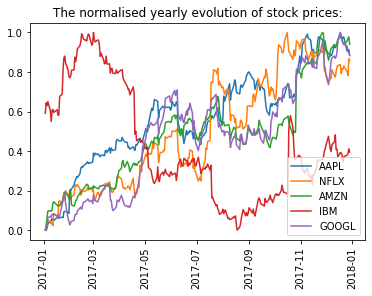

In [39]:
plot_stock_prices(stock_prices) # Using a helper function to plot the stock price

In [40]:
#num of assets (length of our NASDAQ issues array)
num_assets = len(stocks)

# set budget - how many stocks do you want to buy?
budget = 2

In [41]:
# Defining the portfolio optimization problem
portfolio = PortfolioOptimization(expected_returns=stock_prices.get_period_return_mean_vector(), covariances=stock_prices.get_period_return_covariance_matrix(), risk_factor=0.2, budget=budget)
qp = portfolio.to_quadratic_program() # This creates a quadratic program, which is the form in which the problem can be directly passed to Qiskit's solvers

Traceback (most recent call last):
  Input In [41] in <module>
    portfolio = PortfolioOptimization(expected_returns=stock_prices.get_period_return_mean_vector(), covariances=stock_prices.get_period_return_covariance_matrix(), risk_factor=0.2, budget=budget)
  File /opt/conda/lib/python3.8/site-packages/qiskit_finance/data_providers/_base_data_provider.py:113 in get_period_return_mean_vector
    period_returns = _div_func(np.array(self._data)[:, 1:], np.array(self._data)[:, :-1]) - 1
IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Use %tb to get the full traceback.


In [21]:
exact_mes = NumPyMinimumEigensolver() # Specifying the classical solver we want to use - NumPyMinimumEigensolver
exact_eigensolver = MinimumEigenOptimizer(exact_mes) 

result_classical = exact_eigensolver.solve(qp) # Solving the problem using the classical solver

result_classical # Printing the classical result.

optimal function value: -0.011134468629318488
optimal value: [0. 1. 1. 0. 0.]
status: SUCCESS

In [22]:
seed = 123

algorithm_globals.random_seed = 1234
backend = Aer.get_backend('qasm_simulator') # Quantum simulator


quantum_circuit = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')  # This is the quantum part of VQE
cobyla = COBYLA()
cobyla.set_options(maxiter=500) # This is the classical optimizer we will use

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

# Now, we will use VQE to solve this problem
vqe_mes = VQE(quantum_circuit, optimizer=cobyla, quantum_instance=quantum_instance) 

vqe = MinimumEigenOptimizer(vqe_mes)
result_vqe = vqe.solve(qp)

result_vqe

optimal function value: -0.011134468629318488
optimal value: [0. 1. 1. 0. 0.]
status: SUCCESS